<a href="https://colab.research.google.com/github/JaejunHaa/AIB_Project/blob/main/n223a_evaluation_metrics_for_classification_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [1]:
# !pip install --upgrade scikit-learn
# ! pip install -U pandas-profiling
# ! pip install --upgrade category_encoders

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [2]:
# F beta score 구하기
TP = 4442
TN = 6165
FP = 1515
FN = 1930
beta = 2

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f_score = (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

print(f'F beta score = {f_score}')

F beta score = 0.7063126093178566


### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [3]:
# 데이터 불러오기
import pandas as pd
target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [4]:
# 데이터 나누기
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [5]:
# 중복된 샘플을 제거
train.drop_duplicates(inplace = True)

# 중복 샘플 제거 후 샘플 확인
train.duplicated().sum()

0

In [6]:
# 특성 엔지니어링
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def engineer(df):
    
    # behaviorals 관련 새로운 특성 생성
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    # 타겟 변수와 관계 없는 seasonal flu관련 특성 제거
    dels = [col for col in df.columns if 'seas' in col]
    df.drop(columns=dels, inplace=True)
        
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [7]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [8]:
# Target encoding, RamdomForest
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import f1_score

pipe = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, 
                           n_estimators=200, max_depth=11, class_weight='balanced')
)

pipe.fit(X_train, y_train)
print('Training accuracy: ', pipe.score(X_train, y_train))
print('Validation accuracy: ', pipe.score(X_val, y_val))

# f1-score
y_val_pred = pipe.predict(X_val)
print('Validation accuracy(f1_score):', f1_score(y_val, y_val_pred))

Training accuracy:  0.8412215561719006
Validation accuracy:  0.795397936187878
Validation accuracy(f1_score): 0.6252444058222897


In [9]:
# 임계값 변화에 따른 지표 변화 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from sklearn.metrics import classification_report

y_pred_proba = pipe.predict_proba(X_val)[:, 1]

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

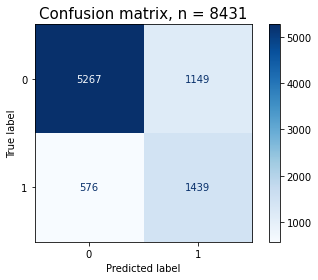

In [10]:
# Confusion matrix 시각화
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


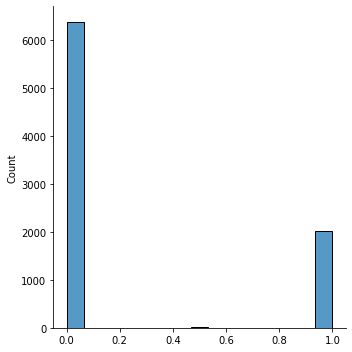

In [11]:
# n_estimator=1
pipe1 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, 
                           max_depth=None, n_estimators=1)
)

pipe1.fit(X_train, y_train)
y_pred_proba1 = pipe1.predict_proba(X_val)[:, 1]

sns.displot(y_pred_proba1);

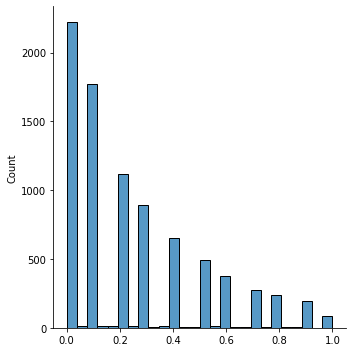

In [12]:
# n_estimator=10
pipe10 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, 
                           max_depth=None, n_estimators=10)
)

pipe10.fit(X_train, y_train)
y_pred_proba10 = pipe10.predict_proba(X_val)[:, 1]

sns.displot(y_pred_proba10);

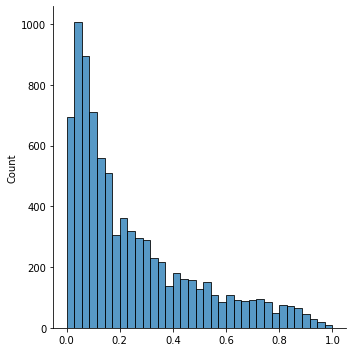

In [13]:
# n_estimator=100
pipe100 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, 
                           max_depth=None, n_estimators=100)
)

pipe100.fit(X_train, y_train)
y_pred_proba100 = pipe100.predict_proba(X_val)[:, 1]

sns.displot(y_pred_proba100);

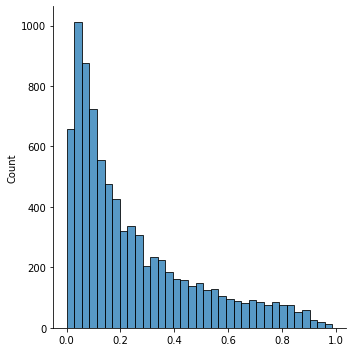

In [14]:
# n_estimator=1000
pipe1000 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, 
                           max_depth=None, n_estimators=1000)
)

pipe1000.fit(X_train, y_train)
y_pred_proba1000 = pipe1000.predict_proba(X_val)[:, 1]

sns.displot(y_pred_proba1000);

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

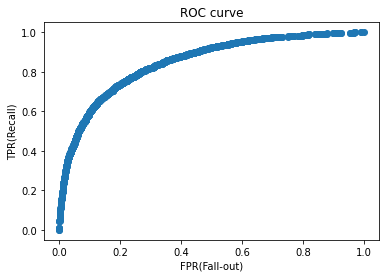

In [15]:
# 기존 모델(TargetEncoder, max_depth=11, n_estimators=200) ROC curve 확인
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [16]:
# AUC점수 계산
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f'AUC score: {auc_score}')

AUC score: 0.8492214717548561


In [17]:
# 새로운 모델
from category_encoders import OrdinalEncoder
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=2, oob_score=True, 
                           max_depth=11, n_estimators=200, min_samples_leaf=3, max_features=0.5, 
                           class_weight='balanced')
)

pipe2.fit(X_train, y_train)
print('Training accuracy: ', pipe2.score(X_train, y_train))
print('Validation accuracy: ', pipe2.score(X_val, y_val))

# f1-score
y_val_pred = pipe2.predict(X_val)
print('Validation accuracy(f1_score):', f1_score(y_val, y_val_pred))

Training accuracy:  0.840744385792252
Validation accuracy:  0.795397936187878
Validation accuracy(f1_score): 0.6252444058222897


AUC score_2: 0.846986751483574


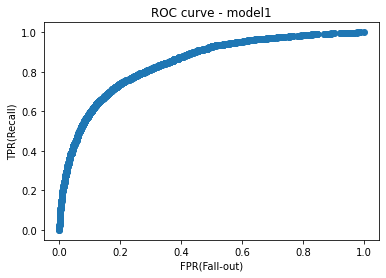

In [18]:
y_pred_proba2 = pipe2.predict_proba(X_val)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_proba2)

plt.scatter(fpr2, tpr2)
plt.title('ROC curve - model1')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)')

auc_score2 = roc_auc_score(y_val, y_pred_proba2)
print(f'AUC score_2: {auc_score2}')

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [19]:
### 이곳에서 과제를 진행해 주세요 ### 